# Introduction

In this section we'll explore the process of developing a benchmarking dataset for Retrieval-Augmented Generation (RAG) using the SEC 10-K filing reports that we processed in the first notebook. A benchmarking dataset is essential for evaluating the performance of models and ensuring they produce high-quality outputs. This notebook aims to guide you through the steps involved in creating such a dataset, including defining question types, categorizing questions, and utilizing the OpenAI API to generate synthetic questions and answers based on the provided financial documents. By the end of this tutorial, you will have a clear understanding of how to build a robust benchmarking dataset that can enhance the capabilities of your RAG models.

**Important**: You must run the first notebook (`01_download_sec-10k_reports.ipynb`) before running this.

## Setup

First we need to load the Python packages that we'll use in this notebook.

In [2]:
#|include: false
%load_ext autoreload
%autoreload 2

In [3]:
import json
from pprint import pprint

Again, most of the custom code developed for this project has been refactored into the `src` folder in the project repository. Refer to this to view details of the code. The modules and functions required for this notebook are loaded below. 

In [4]:
from src.benchmark.dataclasses import QuestionCategory
from src.benchmark.generate import generate_benchmark_question, generate_sec_benchmark_dataset, prepare_question_generation_input
from src.benchmark.qc_dataset import review_questions
from src.benchmark.utils import get_relevant_sections_for_category, determine_question_specification
from src.utils import load_preprocessed_reports_metadata, extract_sections_from_reports

Define some important constants

In [5]:
PROCESSED_REPORTS_DIR = './data/processed/reports' # This is the location where you output the processed reports from notebook one
OUTPUTS_DIR = './data/benchmark' # Directory where the benchmark dataset will be saved

# Generating multi-document questions and answers
In this section we'll review the process of generating benchmark questions and answers from the processed SEC 10-K filing reports. Rather than doing this manually, we will attempt to automate the process by sending selected information to an LLM to generate questions and answer pairs for us. This will allow us to largely automate the generation of a much larger benchmarking dataset later on (although the outputs from the LLM need to be carefully QC'ed).

First let's obtain the metadata of the reports that were processed in the first notebook:


In [6]:
processed_reports_metadata = load_preprocessed_reports_metadata(PROCESSED_REPORTS_DIR)

In [7]:
len(processed_reports_metadata)

50

In [8]:
pprint(processed_reports_metadata[0])

CompanyReport(company_name='NVIDIA CORP',
              ticker='NVDA',
              year=2023,
              raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-23-000017/full-submission.txt',
              industry='SEMICONDUCTORS & RELATED DEVICES [3674]',
              available_sections={'Item 1',
                                  'Item 1A',
                                  'Item 5',
                                  'Item 7',
                                  'Item 7A',
                                  'Item 8'},
              accession_number='0001045810-23-000017')


## Question specification

Our benchmark dataset creation begins with a carefully designed question specification system that ensures meaningful, challenging questions requiring multi-reference synthesis. Rather than randomly selecting content or attempting to process entire reports, we:

**Define Diverse Question Types**

The following question types can be selected:

* **Single-company, single-year**: Questions about one company in a specific year
* **Single-company, multi-year**: Questions requiring temporal analysis across years
* **Multi-company, single-year**: Questions comparing different companies in the same year
* **Multi-company, multi-year**: Complex questions requiring cross-company temporal analysis

**Categorize by Financial Domain Focus**

Define the type of financial question to ask, so we can restrict the report sections to pass in the prompt. These include:

* Financial metrics
* Risk factors
* Business overviews
* Management discussions
* Forward-looking statements
* Segment analyses
* Company stock information
* Table-specific analyses

**Stratify by Difficulty Level**

Define a level of difficulty for the generated question:

* **Easy**: Direct fact retrieval
* **Medium**: Requires understanding multiple parts or basic analysis
* **Hard**: Requires complex reasoning or synthesizing multiple information pieces

Once the basic question specification has been defined we extract relevant context by:

* **Mapping Categories to Relevant Sections**: Each question category is mapped to the most relevant SEC 10-K sections (e.g., risk factor questions focus on Item 1A, financial metrics on Items 7 and 8)
* **Selecting Contextually Appropriate Sections**: Rather than random selection, we choose 1-3 sections most relevant to the question category
* **Balance Token Constraints**: We carefully manage the total token count to ensure it fits within model limits while providing sufficient context

To achieve this a number of functions have been developed. First, based on the question category we can identify the relevant report section using `get_relevant_sections_for_category` function:

In [9]:
get_relevant_sections_for_category(QuestionCategory.BUSINESS_OVERVIEW)

['Item 1']

To generate a question specification, we can use the `determine_question_specification` function. For this we need to pass a dictionary of the reports for each company and it will randomly select which company/year to use for the relevant question type.

In [10]:
companies = {}
for report in processed_reports_metadata:
    if report.ticker not in companies: 
        companies[report.ticker] = {}
    companies[report.ticker][report.year] = report

In [20]:
question_specs = determine_question_specification(companies, PROCESSED_REPORTS_DIR)

In [21]:
pprint(question_specs, sort_dicts=False)

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>,
             category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>,
             difficulty=<QuestionDifficulty.MEDIUM: 'medium'>,
             reports=[CompanyReport(company_name='NVIDIA CORP',
                                    ticker='NVDA',
                                    year=2019,
                                    raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-19-000023/full-submission.txt',
                                    industry='SEMICONDUCTORS & RELATED DEVICES '
                                             '[3674]',
                                    available_sections={'Item 1',
                                                        'Item 1A',
                                                        'Item 5',
                                                        'Item 7',
                                                        'Item 7A',
       

In the example above, a question involving one company across multiple years based on risk factors was chosen. Based on this, it randomly selected Nvidia as the company, 2016 and 2019 as the two years, and Item 5 from the report (since the question type is risk factors).

## Extract sections from processed reports

Once the question specification has been defined, the `extract_sections_from_reports` function is used to get the related information from the processed reports.

In [22]:
extracted_sections = extract_sections_from_reports(question_specs, PROCESSED_REPORTS_DIR)

In [25]:
extracted_sections

{'NVDA': {2019: {'Item 5': '**ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES**\n\nOur common stock is traded on the Nasdaq Global Select Market under the symbol NVDA. Public trading of our common stock began on January 22,1999. Prior to that, there was no public market for our common stock. As of February 15,2019 , we had approximately 317 registered shareholders, not including those shares held in street or nominee name.\n\n **Issuer Purchases of Equity Securities**\n\nBeginning August 2004, our Board of Directors authorized us to repurchase our stock.\n\nSince the inception of our share repurchase program, we have repurchased an aggregate of 260 million shares for a total cost of $7.08 billion through January 27,2019 . All shares delivered from these repurchases have been placed into treasury stock.\n\nIn November 2018, the Board authorized an additional $7.00 billion under our share repurchase program and extended

Now we use the `prepare_question_generation_input` function to format the content that will be sent to the LLM. Note that we have an option to exclude tabular data. Since the reports contain a lot of tables (particularly Item 8), we'll exclude this from our workflow from now. This requires additional workflows to properly embed the content for a RAG pipeline.

In [26]:
formatted_content, content_metadata = prepare_question_generation_input(question_specs, extracted_sections, exclude_tables=True)

In [28]:
pprint(formatted_content)

('COMPANY: NVDA\n'
 '\n'
 'YEAR: 2016\n'
 '\n'
 'SECTION: Item 5\n'
 '\n'
 '**ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS '
 'AND ISSUER PURCHASES OF EQUITY SECURITIES**\n'
 '\n'
 'Our common stock is traded on the NASDAQ Global Select Market under the '
 'symbol NVDA. Public trading of our common stock began on January 22,1999. '
 'Prior to that, there was no public market for our common stock. As of March '
 '11,2016, we had approximately 342 registered shareholders, not including '
 'those shares held in street or nominee name. The following table sets forth '
 'for the periods indicated the high and low sales price for our common stock '
 'as quoted on the NASDAQ Global Select Market:\n'
 '\n'
 ' \n'
 '\n'
 '[TABLE REMOVED]\n'
 '\n'
 ' **Dividend Policy**\n'
 '\n'
 'On May 7,2015, we increased our quarterly cash dividend from $0.085 per '
 'share to $0.0975 per share, or $0.39 on an annual basis. On November 5,2015, '
 'we again increased our quarterl

## Generate question
Now we're ready to test creating a benchmark question using an LLM. In this case, we'll use the `generate_benchmark_question` function to send a request to the OpenAI API.

**Important**: You need to ensure that you've added your OpenAI API key to the `OPENAI_API_KEY` environment variable.


In [29]:
generated_question = generate_benchmark_question(question_specs, formatted_content, content_metadata)

In [30]:
pprint(generated_question.__dict__, width=100, sort_dicts=False)

{'id': None,
 'question': "How did NVIDIA's cash dividends and share repurchase activities compare between 2016 "
             'and 2019?',
 'answer': 'In 2016, NVIDIA paid $213 million in cash dividends to shareholders, while in 2015, '
           'the amount was $186 million. The quarterly cash dividend increased from $0.085 per '
           'share in 2015 to $0.115 per share in 2016. In terms of share repurchases, as of '
           'January 31, 2016, NVIDIA had repurchased 231 million shares for a total cost of $3.85 '
           'billion. By 2019, NVIDIA had repurchased a total of 260 million shares for $7.08 '
           'billion, and they planned to return $3.00 billion to shareholders by the end of fiscal '
           'year 2020, which included $700 million of share repurchases made in the fourth quarter '
           'of fiscal year 2019.',
 'source_information': [SourceInformation(company='NVIDIA', ticker='NVDA', year='2016', section='Item 5', subsection='Dividend Policy', spa

The response includes the following:

* **Question and answer**: A question and answer are generated by the LLM based on the documents and question type we submitted
* **Source information**: The LLM is also asked to extract the exact references it used in order to answer the question. This is essential information for us when it comes to evaluating RAG pipelines.
* **Reasoning path**: Although not required now, it also outputs a potential reasoning path to answer the questions. This could be useful for fine-tuning a reasoning model.

# Generate multiple questions

Now we'll use the `generate_sec_benchmark_dataset` function to generate multiple questions. This has a number of options, including:

* **Number of questions**: We were only asked to include 10 questions for our benchmark for the assignment (in reality we would want more). However, the model will generate questions that are incorrect (e.g. references missing) or are unsuitable, so we need to specify more than we need.
* **Model**: Here you can specify which model from the OpenAI API to use. I found the `gpy-4o-mini` model to be less reliable, particularly with outputting the references. I use the `gpt-4-turbo` model here, but note that this is more expensive.
* **Exclude tables**: For the time being we will drop tables from the dataset. Tables will require additional processing for using in a RAG pipeline which we will revisit later.

In [45]:
#| output: false
benchmark_questions = generate_sec_benchmark_dataset(preprocessed_dir=PROCESSED_REPORTS_DIR,
                                                   output_dir=OUTPUTS_DIR,
                                                   num_questions=50,
                                                   model='gpt-4-turbo',
                                                   max_tokens_per_section=15000,
                                                   exclude_tables=True)

Loading preprocessed reports from ./data/processed/reports...
Loaded 50 preprocessed reports
Found data for 5 companies
  - NVDA: 10 years (2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025)
  - AAPL: 10 years (2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024)
  - GOOG: 10 years (2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025)
  - MSFT: 10 years (2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024)
  - AMZN: 10 years (2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025)
Generating 50 benchmark questions...


  0%|          | 0/50 [00:00<?, ?it/s]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2015, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001193125-15-272806/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001193125-15-272806')], sections_to_include={'./data/processed/reports/report_MSFT_2015.json': ['Item 7', 'Item 8']})


  2%|▏         | 1/50 [00:20<16:49, 20.60s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.TABLE_ANALYSIS: 'table_analysis'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2017, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-17-000011/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-17-000011'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2017, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-17-000008/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-17-000008')], sections_to_include={'./data/processed/reports/report_AMZN_2017.json'

  4%|▍         | 2/50 [00:46<18:53, 23.61s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.HARD: 'hard'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2016, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001193125-16-662209/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5'}, accession_number='0001193125-16-662209'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2017, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-17-014900/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-17-014900')], sections_to_include={'./data/processed/reports/report_MSFT_2016.json': ['Item 5'], './data/processed/reports/report_

  6%|▌         | 3/50 [01:14<20:00, 25.55s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.COMPANY_STOCK: 'company_stock'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2022, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-22-000019/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-22-000019')], sections_to_include={'./data/processed/reports/report_GOOG_2022.json': ['Item 7A', 'Item 1A']})


  8%|▊         | 4/50 [01:40<19:45, 25.78s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FORWARD_LOOKING: 'forward_looking'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2022, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-22-000036/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-22-000036'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2022, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-22-000005/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-22-000005'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2022, raw_file_path='./data/r

 10%|█         | 5/50 [02:05<19:15, 25.69s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.BUSINESS_OVERVIEW: 'business_overview'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2024, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-24-000008/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-24-000008')], sections_to_include={'./data/processed/reports/report_AMZN_2024.json': ['Item 1']})


 12%|█▏        | 6/50 [02:28<18:10, 24.78s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2016, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001193125-16-662209/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5'}, accession_number='0001193125-16-662209'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2016, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-16-000205/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-16-000205')], sections_to_include={'./data/processed/reports/report_MSFT_2016.json': ['Item 8'], './data/processed/r

 14%|█▍        | 7/50 [02:45<15:55, 22.23s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2019, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-19-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-19-000004')], sections_to_include={'./data/processed/reports/report_AMZN_2020.json': ['Item 5'], './data/proce

 16%|█▌        | 8/50 [03:00<13:52, 19.83s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2017, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-17-000011/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-17-000011'), CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2017, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-17-000070/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-17-000070')], sections_to_include={'./data/processed/reports/report_AMZN_2017.json': ['Item 7'], './data/processed/repo

 18%|█▊        | 9/50 [03:45<18:56, 27.73s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FORWARD_LOOKING: 'forward_looking'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2018, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-18-019062/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-18-019062')], sections_to_include={'./data/processed/reports/report_MSFT_2018.json': ['Item 7']})
Error parsing JSON response: Expecting value: line 1 column 1 (char 0)
Response content: {
    "question": "Can you tell me how many tables were included in the Management's Discussion and Analysis section of MSFT's 2018 SEC 10-K filing?",
    "answer": "The Management's Discussion and Analysis section of MSFT's 2018 SEC 10-K filing included a tota

 20%|██        | 10/50 [06:03<41:05, 61.63s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2023, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-23-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-23-000004'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2023, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-23-000106/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-23-000106'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2023, raw_file_path='./data/raw/sec-edg

 22%|██▏       | 11/50 [06:34<33:56, 52.21s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2022, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-22-026876/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-22-026876'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2022, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-22-000036/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-22-000036')], sections_to_include={'./data/processed/reports/report_MSFT_2022.json': ['Item 5'], './data/processed/repor

 24%|██▍       | 12/50 [06:50<26:07, 41.26s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2024, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-24-000008/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-24-000008'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2016, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-16-000172/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-16-000172')], sections_to_include={'./data/processed/reports/report_AMZN_2024.json': ['Item 8', 'Ite

 26%|██▌       | 13/50 [07:07<20:57, 33.97s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004')], sections_to_include={'./data/processed/reports/report_AMZN_2020.json': ['Item 7']})


 28%|██▊       | 14/50 [07:20<16:39, 27.77s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.BUSINESS_OVERVIEW: 'business_overview'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2022, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-22-000036/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-22-000036'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2016, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-16-000205/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-16-000205')], sections_to_include={'./data/processed/reports/report_NVDA_2022.json': ['Item 1'], './data

 30%|███       | 15/50 [07:45<15:38, 26.80s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.FORWARD_LOOKING: 'forward_looking'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2019, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-19-000023/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-19-000023'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2023, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-23-000017/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-23-000017')], sections_to_include={'./data/processed/reports/report_NVDA_2019.json': ['Item 7'], './data/process

 32%|███▏      | 16/50 [08:00<13:12, 23.32s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2018, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-18-000007/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-18-000007')], sections_to_include={'./data/processed/reports/report_GOOG_2018.json': ['Item 8', 'Item 7']})


 34%|███▍      | 17/50 [08:20<12:18, 22.39s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.TABLE_ANALYSIS: 'table_analysis'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2023, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-23-000106/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-23-000106'), CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/000

 36%|███▌      | 18/50 [08:49<12:57, 24.29s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2019, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-19-000119/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-19-000119'), CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2017, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-17-000070/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-17-000070')], sections_to_include={'./data/processed/reports/report_AAPL_2019.json': ['Item 5'], './data/processed/reports/report_AAPL_2017.jso

 38%|███▊      | 19/50 [09:05<11:11, 21.68s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2025, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-25-000023/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-25-000023')], sections_to_include={'./data/processed/reports/report_NVDA_2025.json': ['Item 7', 'Item 8']})


 40%|████      | 20/50 [09:42<13:08, 26.30s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-18-000005/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-18-000005'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2021, ra

 42%|████▏     | 21/50 [10:02<11:51, 24.54s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2019, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-19-000023/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-19-000023')], sections_to_include={'./data/processed/reports/report_NVDA_2019.json': ['Item 8', 'Item 7']})


 44%|████▍     | 22/50 [10:30<11:50, 25.38s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.BUSINESS_OVERVIEW: 'business_overview'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2022, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-22-000108/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-22-000108')], sections_to_include={'./data/processed/reports/report_AAPL_2018.json': ['Item 1'], './data/processed/reports/report_A

 46%|████▌     | 23/50 [10:55<11:21, 25.26s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2024, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-24-000008/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-24-000008'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2023, raw_file_pat

 48%|████▊     | 24/50 [11:20<10:55, 25.21s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.COMPANY_STOCK: 'company_stock'>, difficulty=<QuestionDifficulty.HARD: 'hard'>, reports=[CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145'), CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2016, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0001628280-16-020309/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001628280-16-020309')], sections_to_include={'./data/processed/reports/report_AAPL_2018.json': ['Item 5', 'Item 7A'], './data/processed/reports/report_AAP

 50%|█████     | 25/50 [11:42<10:10, 24.42s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2023, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-23-000106/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-23-000106')], sections_to_include={'./data/processed/reports/report_AAPL_2023.json': ['Item 8']})


 52%|█████▏    | 26/50 [12:06<09:41, 24.21s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2020, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-20-000008/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-20-000008')], sections_to_include={'./data/processed/reports/report_AMZN_2020.json'

 54%|█████▍    | 27/50 [12:21<08:10, 21.34s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2019, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-19-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-19-000004'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2019, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-19-000004/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-19-000004')], sections_to_include={'./data/processed/reports/report_AMZN_2019.j

 56%|█████▌    | 28/50 [12:50<08:43, 23.79s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.TABLE_ANALYSIS: 'table_analysis'>, difficulty=<QuestionDifficulty.HARD: 'hard'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2021, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-21-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-21-000004'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2021, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-21-000105/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-21-000105'), CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2021, raw_file_path='./data/raw/sec-edgar-filin

 58%|█████▊    | 29/50 [13:21<09:07, 26.07s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145')], sections_to_include={'./data/processed/reports/report_AAPL_2018.json': ['Item 5']})


 60%|██████    | 30/50 [13:38<07:47, 23.36s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.COMPANY_STOCK: 'company_stock'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-20-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-20-000004'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2020, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-20-000096/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-20-000096')], sections_to_include={'./data/processed/reports/report_AMZN_2020.json': ['Item 7', 'Item 7A'], './data/processe

 62%|██████▏   | 31/50 [13:58<07:03, 22.26s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2015, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001193125-15-272806/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001193125-15-272806'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2019, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-19-027952/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-19-027952'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2021, raw_file_path='.

 64%|██████▍   | 32/50 [14:17<06:24, 21.34s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.BUSINESS_OVERVIEW: 'business_overview'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2025, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-25-000023/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-25-000023')], sections_to_include={'./data/processed/reports/report_NVDA_2025.json': ['Item 1']})


 66%|██████▌   | 33/50 [14:58<07:40, 27.09s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FORWARD_LOOKING: 'forward_looking'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2018, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-18-019062/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-18-019062')], sections_to_include={'./data/processed/reports/report_MSFT_2018.json': ['Item 7']})


 68%|██████▊   | 34/50 [15:14<06:20, 23.79s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2017, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-17-000011/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-17-000011')], sections_to_include={'./data/processed/reports/report_AMZN_2017.json': ['Item 7']})


 70%|███████   | 35/50 [15:30<05:21, 21.45s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.COMPANY_STOCK: 'company_stock'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2024, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-24-000123/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-24-000123')], sections_to_include={'./data/processed/reports/report_AAPL_2024.json': ['Item 1A']})


 72%|███████▏  | 36/50 [15:58<05:26, 23.31s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2017, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-17-000008/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-17-000008')], sections_to_include={'./data/processed/reports/report_GOOG_2017.json': ['Item 7']})


 74%|███████▍  | 37/50 [16:24<05:13, 24.10s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2025, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-25-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-25-000004'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2022, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-22-000005/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-22-000005'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2021, ra

 76%|███████▌  | 38/50 [16:51<05:02, 25.17s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2016, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-16-000172/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-16-000172'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2021, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-21-000004/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-21-000004'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2022, raw_file_pat

 78%|███████▊  | 39/50 [17:16<04:36, 25.15s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145'), CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2016, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0001628280-16-020309/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001628280-16-020309')], sections_to_include={'./data/processed/reports/report_AAPL_2018.json': ['Item 7'], './data/processed/reports/r

 80%|████████  | 40/50 [17:47<04:29, 26.92s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2018, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-18-000007/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-18-000007'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2024, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-24-000022/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-24-000022')], sections_to_include={'./data/processed/rep

 82%|████████▏ | 41/50 [18:14<04:01, 26.87s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='NVIDIA CORP', ticker='NVDA', year=2021, raw_file_path='./data/raw/sec-edgar-filings/NVDA/10-K/0001045810-21-000010/full-submission.txt', industry='SEMICONDUCTORS & RELATED DEVICES [3674]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001045810-21-000010'), CompanyReport(company_name='Apple Inc.', ticker='AAPL', year=2021, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-21-000105/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-21-000105')], sections_to_include={'./data/processed/reports/report_NVDA_2021.json': ['Item 7'], './data/proc

 84%|████████▍ | 42/50 [18:43<03:38, 27.37s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.HARD: 'hard'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2021, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-21-000010/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-21-000010')], sections_to_include={'./data/processed/reports/report_GOOG_2021.json': ['Item 8', 'Item 7']})


 86%|████████▌ | 43/50 [19:03<02:57, 25.29s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2018, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-18-000007/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-18-000007')], sections_to_include={'./data/processed/reports/report_GOOG_2018.json': ['Item 7']})


 88%|████████▊ | 44/50 [19:29<02:33, 25.52s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='APPLE INC', ticker='AAPL', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AAPL/10-K/0000320193-18-000145/full-submission.txt', industry='ELECTRONIC COMPUTERS [3571]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000320193-18-000145'), CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-18-000005/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-18-000005'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2018, raw_file_path='./data/raw/sec-e

 90%|█████████ | 45/50 [19:56<02:09, 25.92s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_SINGLE_YEAR: 'single_company_single_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='AMAZON COM INC', ticker='AMZN', year=2018, raw_file_path='./data/raw/sec-edgar-filings/AMZN/10-K/0001018724-18-000005/full-submission.txt', industry='RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001018724-18-000005')], sections_to_include={'./data/processed/reports/report_AMZN_2018.json': ['Item 7', 'Item 8']})


 92%|█████████▏| 46/50 [20:19<01:40, 25.16s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.FINANCIAL_METRIC: 'financial_metric'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2024, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0000950170-24-087843/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000950170-24-087843'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2020, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-20-034944/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-20-034944'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2022, raw_file_path='./data/

 94%|█████████▍| 47/50 [20:48<01:18, 26.11s/it]

QuestionSpec(question_type=<QuestionType.MULTI_COMPANY_SINGLE_YEAR: 'multi_company_single_year'>, category=<QuestionCategory.MANAGEMENT_DISCUSSION: 'management_discussion'>, difficulty=<QuestionDifficulty.MEDIUM: 'medium'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2023, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0000950170-23-035122/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0000950170-23-035122'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2023, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-23-000016/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-23-000016')], sections_to_include={'./data/processed/reports/report_MSFT_2

 96%|█████████▌| 48/50 [21:14<00:52, 26.15s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.RISK_FACTOR: 'risk_factor'>, difficulty=<QuestionDifficulty.EASY: 'easy'>, reports=[CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2022, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-22-000019/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-22-000019'), CompanyReport(company_name='Alphabet Inc.', ticker='GOOG', year=2016, raw_file_path='./data/raw/sec-edgar-filings/GOOG/10-K/0001652044-16-000012/full-submission.txt', industry='SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC. [7370]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001652044-16-000012')], sections_to_include={'./data/processed/reports/report_GOOG_202

 98%|█████████▊| 49/50 [21:36<00:24, 24.88s/it]

QuestionSpec(question_type=<QuestionType.SINGLE_COMPANY_MULTI_YEAR: 'single_company_multi_year'>, category=<QuestionCategory.SEGMENT_ANALYSIS: 'segment_analysis'>, difficulty=<QuestionDifficulty.HARD: 'hard'>, reports=[CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2022, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-22-026876/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-22-026876'), CompanyReport(company_name='MICROSOFT CORP', ticker='MSFT', year=2021, raw_file_path='./data/raw/sec-edgar-filings/MSFT/10-K/0001564590-21-039151/full-submission.txt', industry='SERVICES-PREPACKAGED SOFTWARE [7372]', available_sections={'Item 8', 'Item 7A', 'Item 1A', 'Item 1', 'Item 5', 'Item 7'}, accession_number='0001564590-21-039151')], sections_to_include={'./data/processed/reports/report_MSFT_2022.json': ['Item 8', 'Item 7'], './

100%|██████████| 50/50 [22:04<00:00, 26.49s/it]

Saving 50 questions to ./data/benchmark/benchmark_dataset.json...
Done!


In [40]:
benchmark_questions[0:10]

[BenchmarkQuestion(id='e8f9266c-5229-420f-969b-ff3c709987cc', question='Can you tell me about the effectiveness of internal controls over financial reporting for Alphabet and Google in 2015?', answer="In 2015, both Alphabet Inc. and Google Inc. maintained effective internal control over financial reporting. The report from Ernst & Young LLP expressed an unqualified opinion on Alphabet Inc.'s internal control over financial reporting as of December 31, 2015, stating, 'In our opinion, Alphabet Inc. maintained, in all material respects, effective internal control over financial reporting as of December 31, 2015, based on the COSO criteria.' Similarly, the report for Google Inc. stated, 'In our opinion, Google Inc. maintained, in all material respects, effective internal control over financial reporting as of December 31, 2015, based on the COSO criteria.'", source_information=[SourceInformation(company='Alphabet Inc.', ticker='GOOG', year='2016', section='Item 8', subsection='Report of Er

# QC questions
The current implementation does not always output suitable questions for the benchmarking dataset. Common issues include:

* Incomplete references
* Questions that don't make sense
* Answers that don't completely correspond to the provided references

Therefore it is vital that each question is reviewed before using it in the benchmarking dataset. The `review_questions` function was developed to help with this task. For each question, this will search for the reference output by the LLM in the original report and highlight the closest match so that it can be verified. The tool still needs some work, but it might be helpful (otherwise you can just do a manual review).

In [42]:
#| output: false
reviewer = review_questions(benchmark_questions, output_dir=OUTPUTS_DIR)

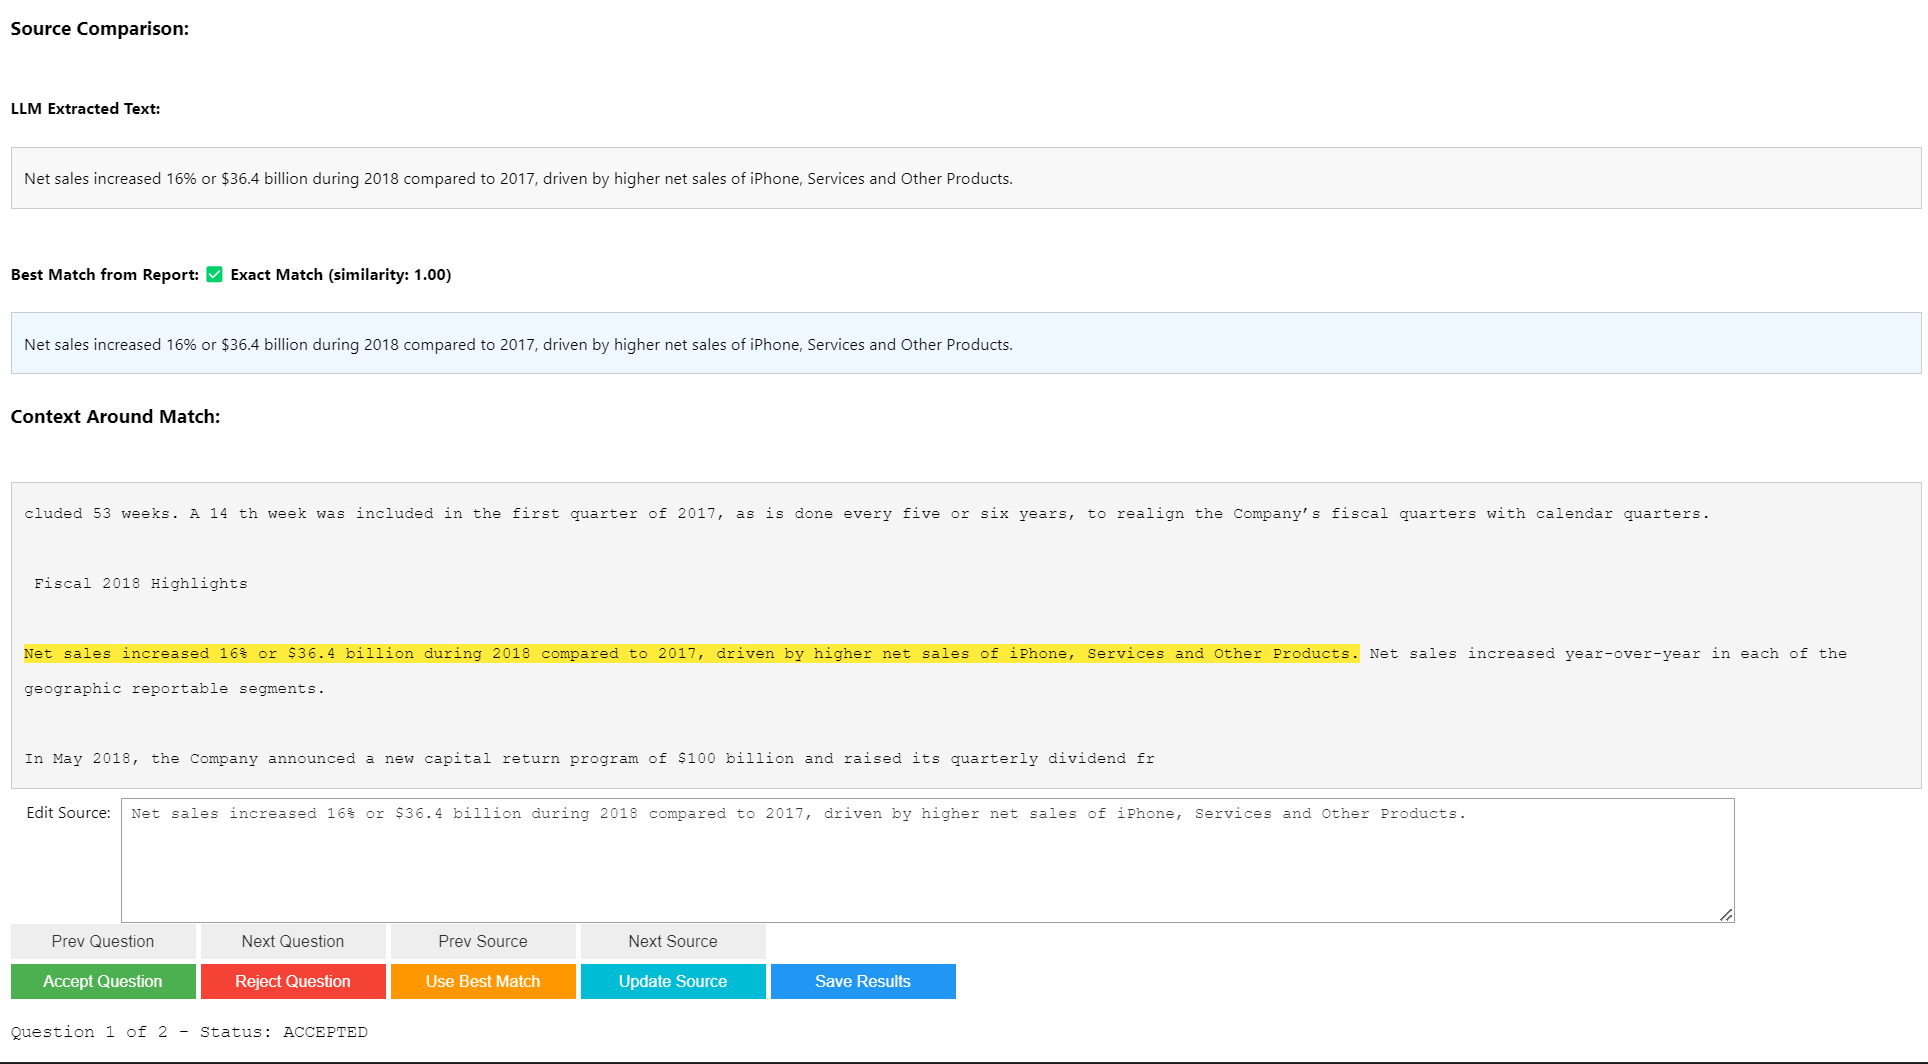

# Final benchmark dataset

If you're re-running this notebook then the questions and answers that you generate will be different to what was obtained here. The final benchmarking dataset has been copied into the `examples` folder of the repo.

The first three questions are displayed below:

In [2]:
#| echo: false

# Load the JSON file
with open('./examples/benchmark_dataset_reviewed.json', 'r') as file:
    benchmark_data = json.load(file)

# Display the data in a nice format
pprint(benchmark_data[0:3], width=100, sort_dicts=False)


[{'id': 'd9fd9582-4495-4310-a142-8d3beb5e0d1e',
  'question': 'How many shares did Apple buy back in 2020 compared to 2021?',
  'answer': 'In 2020, Apple repurchased 917 million shares of its common stock for $72.5 billion, '
            'while in 2021, the company repurchased $85.5 billion of its common stock.',
  'source_information': [{'company': 'Apple',
                          'ticker': 'AAPL',
                          'year': '2020',
                          'section': 'Item 7',
                          'subsection': 'Capital Return Program',
                          'span_text': 'As of September 26, 2020, the Company was authorized to '
                                       'purchase up to $225 billion of the Company’s common stock '
                                       'under a share repurchase program, of which $168.6 billion '
                                       'had been utilized. During 2020, the Company repurchased '
                                       '917 

# Summary

This notebook demonstrates the process of creating a multi-document RAG benchmarking dataset using SEC 10-K filings:

1. Define question specifications (type, category, difficulty)
2. Extract relevant sections from preprocessed reports
3. Generate questions and answers using OpenAI's API
4. Perform quality control on generated questions
5. Review and finalize the benchmark dataset

Key steps include:
- Using custom functions to automate question generation
- Handling various question types (single/multi-company, single/multi-year)
- Excluding tables for simplified processing
- Implementing a review process for quality assurance

The resulting dataset will be used to evaluate different RAG pipelines for answerig questions about SEC 10-K filing reports.
